In [1]:
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

# 1. Cargar y preparar datos
df = pd.read_csv("top_20_corr.csv")
df['periodo'] = pd.to_datetime(df['periodo'])

# 2. Agrupar por producto y mes
df_prod = df.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()

# 3. Crear features adicionales
febreros = df_prod[df_prod['periodo'].dt.month == 2]
febrero_hist = febreros[febreros['periodo'].dt.year < 2020].groupby('product_id')['tn'].mean().reset_index()
febrero_hist.rename(columns={'tn': 'febrero_hist'}, inplace=True)

df_prod = df_prod.sort_values(['product_id', 'periodo'])
df_prod['media_movil_12m'] = (
    df_prod.groupby('product_id')['tn']
    .transform(lambda x: x.rolling(window=12, min_periods=1).mean())
)

# 4. Crear lags
def crear_lags(df, lags=[1, 2, 3]):
    df_lags = df.copy()
    for lag in lags:
        df_lags[f'lag_{lag}'] = df_lags.groupby('product_id')['tn'].shift(lag)
    return df_lags

df_lags = crear_lags(df_prod)
df_lags['mes'] = df_lags['periodo'].dt.month

# 5. Calcular deltas
df_lags['var_lag1_lag2'] = df_lags['lag_1'] / df_lags['lag_2']
df_lags['delta_lag1_lag2'] = df_lags['lag_1'] - df_lags['lag_2']
df_lags['delta_rel_lag1_lag2'] = df_lags['delta_lag1_lag2'] / df_lags['lag_2']
df_lags['delta_ma12_lag1'] = df_lags['lag_1'] - df_lags['media_movil_12m']
df_lags.replace([float('inf'), -float('inf')], pd.NA, inplace=True)

# 6. Preparar entrenamiento y validación
df_train = df_lags.dropna()
features = [
    'lag_1', 'lag_2', 'lag_3', 'mes', 'media_movil_12m',
    'var_lag1_lag2', 'delta_lag1_lag2', 'delta_rel_lag1_lag2', 'delta_ma12_lag1'
]
target = 'tn'

X_train = df_train[df_train['periodo'] < '2019-12-01'][features].astype('float32')
y_train = df_train[df_train['periodo'] < '2019-12-01'][target]

X_val = df_train[df_train['periodo'] == '2019-12-01'][features].astype('float32')
y_val = df_train[df_train['periodo'] == '2019-12-01'][target]

# 7. Entrenar modelo
mejores_params = {
    'n_estimators': 200,
    'learning_rate': 0.03244248607245155,
    'max_depth': 7,
    'num_leaves': 214,
    'subsample': 0.5578159124217413,
    'colsample_bytree': 0.8356752549785926,
    'random_state': 42,
    'min_data_in_leaf': 28,
    'reg_alpha': 0.2821665266006608,
    'reg_lambda': 2.364955845083401,
    'linear_tree': True
}
modelo = lgb.LGBMRegressor(**mejores_params)
modelo.fit(X_train, y_train)

# 8. Validación
y_pred_val = modelo.predict(X_val)
print("📊 MAE en diciembre 2019:", mean_absolute_error(y_val, y_pred_val))

# 9. Predicción enero 2020
enero_df = df_prod[df_prod['periodo'] == '2019-12-01'].copy()
enero_df['periodo'] = pd.to_datetime('2020-01-01')
enero_df['lag_1'] = df_prod[df_prod['periodo'] == '2019-12-01']['tn'].values
enero_df['lag_2'] = df_prod[df_prod['periodo'] == '2019-11-01']['tn'].values
enero_df['lag_3'] = df_prod[df_prod['periodo'] == '2019-10-01']['tn'].values
enero_df['mes'] = 1
enero_df['media_movil_12m'] = df_prod[df_prod['periodo'] == '2019-12-01']['media_movil_12m'].values
enero_df['var_lag1_lag2'] = enero_df['lag_1'] / enero_df['lag_2']
enero_df['delta_lag1_lag2'] = enero_df['lag_1'] - enero_df['lag_2']
enero_df['delta_rel_lag1_lag2'] = enero_df['delta_lag1_lag2'] / enero_df['lag_2']
enero_df['delta_ma12_lag1'] = enero_df['lag_1'] - enero_df['media_movil_12m']
enero_df.replace([float('inf'), -float('inf')], pd.NA, inplace=True)

enero_df['tn'] = modelo.predict(enero_df[features].astype('float32'))

# 10. Predicción febrero 2020
feb_df = pd.DataFrame()
feb_df['product_id'] = enero_df['product_id']
feb_df['periodo'] = pd.to_datetime('2020-02-01')
feb_df['lag_1'] = enero_df['tn']
feb_df['lag_2'] = df_prod[df_prod['periodo'] == '2019-12-01']['tn'].values
feb_df['lag_3'] = df_prod[df_prod['periodo'] == '2019-11-01']['tn'].values
feb_df['mes'] = 2
feb_df['media_movil_12m'] = df_prod[df_prod['periodo'] == '2019-12-01']['media_movil_12m'].values
feb_df['var_lag1_lag2'] = feb_df['lag_1'] / feb_df['lag_2']
feb_df['delta_lag1_lag2'] = feb_df['lag_1'] - feb_df['lag_2']
feb_df['delta_rel_lag1_lag2'] = feb_df['delta_lag1_lag2'] / feb_df['lag_2']
feb_df['delta_ma12_lag1'] = feb_df['lag_1'] - feb_df['media_movil_12m']
feb_df.replace([float('inf'), -float('inf')], pd.NA, inplace=True)

# Merge con febrero histórico
feb_df = feb_df.merge(febrero_hist, on='product_id', how='left')

# 11. Predicción
feb_df['tn_predicho'] = modelo.predict(feb_df[features].astype('float32'))
feb_df['tn_predicho_ajustada'] = 0.8 * feb_df['tn_predicho'] + 0.2 * feb_df['febrero_hist']

# 12. Exportar
resultado = feb_df[['product_id', 'tn_predicho_ajustada']].rename(columns={'tn_predicho_ajustada': 'tn_predicho'})
resultado.to_csv("prediccion_feb2020_top20_1.csv", index=False)
print("✅ Predicción febrero 2020 guardada en prediccion_feb2020_top20_1.csv")


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2053
[LightGBM] [Info] Number of data points in the train set: 4260, number of used features: 9
[LightGBM] [Info] Start training from score 46.448501
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

In [3]:
import pandas as pd

# 1. Cargar predicción de febrero 2020
df_pred = pd.read_csv("prediccion_feb2020_top20_1.csv")  # archivo generado por el modelo
df_pred['periodo'] = pd.to_datetime("2020-02-01")
df_pred.rename(columns={'tn_predicho': 'tn'}, inplace=True)

# 2. Cargar dataset original
df_real = pd.read_csv("top_20_corr.csv")
df_real["periodo"] = pd.to_datetime(df_real["periodo"])

# 3. Agrupar por período y sumar toneladas reales
tn_reales = df_real.groupby(["periodo"])["tn"].sum().reset_index()

# 4. Sumar toneladas predichas para febrero 2020
tn_feb2020 = df_pred.groupby("periodo")["tn"].sum().reset_index()

# 5. Unir y ordenar
comparacion = pd.concat([tn_reales, tn_feb2020], ignore_index=True)
comparacion = comparacion.sort_values("periodo").reset_index(drop=True)

# 6. Mostrar resultado
print("📊 Total de toneladas por período (incluye predicción febrero 2020):")
print(comparacion.tail(36))  # los últimos 12 períodos


📊 Total de toneladas por período (incluye predicción febrero 2020):
      periodo           tn
1  2017-02-01  5702.329240
2  2017-03-01  6990.975080
3  2017-04-01  5915.823280
4  2017-05-01  6350.693500
5  2017-06-01  6246.929910
6  2017-07-01  4963.102670
7  2017-08-01  5394.165890
8  2017-09-01  6456.906460
9  2017-10-01  7469.616590
10 2017-11-01  6673.993390
11 2017-12-01  5439.856720
12 2018-01-01  5008.784730
13 2018-02-01  5276.024020
14 2018-03-01  8091.698880
15 2018-04-01  5935.535300
16 2018-05-01  6872.360550
17 2018-06-01  6240.219870
18 2018-07-01  5481.642500
19 2018-08-01  6211.813170
20 2018-09-01  5654.181890
21 2018-10-01  6470.025550
22 2018-11-01  6228.277660
23 2018-12-01  4976.507710
24 2019-01-01  5998.069700
25 2019-02-01  6210.342500
26 2019-03-01  6873.226760
27 2019-04-01  6573.771380
28 2019-05-01  6877.301310
29 2019-06-01  6301.710090
30 2019-07-01  6554.508120
31 2019-08-01  5666.678680
32 2019-09-01  7172.001220
33 2019-10-01  7370.981940
34 2019-11-01 


📌 Importancia de variables:
               feature  importancia
3                  mes         1027
4      media_movil_12m          949
0                lag_1          803
8      delta_ma12_lag1          769
1                lag_2          743
2                lag_3          737
6      delta_lag1_lag2          485
5        var_lag1_lag2          457
7  delta_rel_lag1_lag2           92


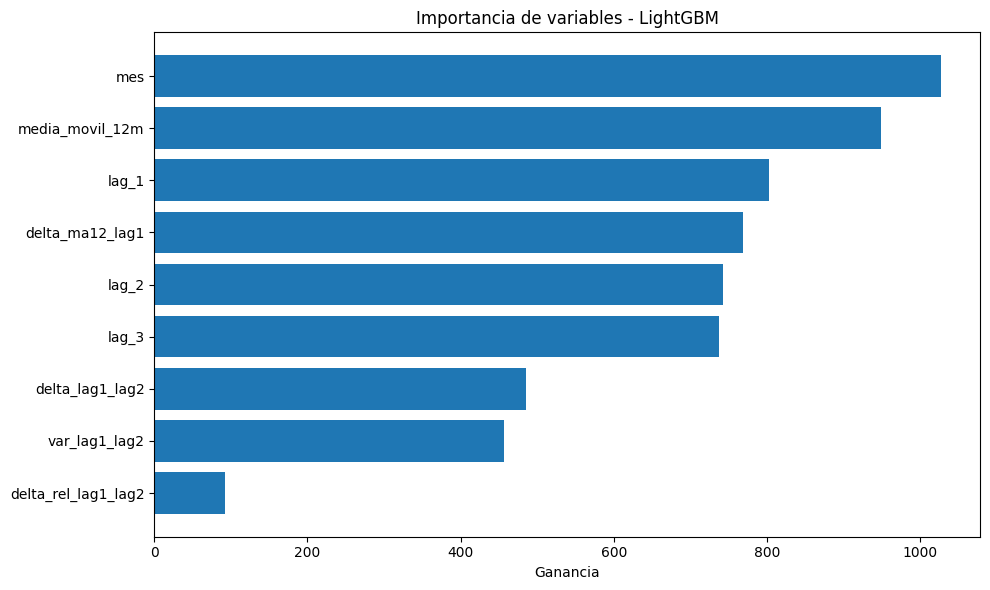

In [4]:
# 🔍 Importancia de variables
import matplotlib.pyplot as plt

# Crear DataFrame con la importancia
importancias = pd.DataFrame({
    'feature': modelo.feature_name_,
    'importancia': modelo.feature_importances_
}).sort_values(by='importancia', ascending=False).head(10)

# Mostrar en consola
print("\n📌 Importancia de variables:")
print(importancias)

# Graficar
plt.figure(figsize=(10, 6))
plt.barh(importancias['feature'], importancias['importancia'])
plt.gca().invert_yaxis()
plt.title("Importancia de variables - LightGBM")
plt.xlabel("Ganancia")
plt.tight_layout()
plt.show()


In [5]:
# Comparación por producto
comparacion = feb_df[['product_id', 'tn_predicho', 'tn_predicho_ajustada', 'febrero_hist']].copy()

# Totales agregados
total_modelo = comparacion['tn_predicho'].sum()
total_ajustada = comparacion['tn_predicho_ajustada'].sum()
total_febrero_hist = comparacion['febrero_hist'].sum()

print("🔎 Comparación de totales:")
print(f"📉 Predicción solo modelo...........: {total_modelo:,.2f} tn")
print(f"⚖️  Predicción ajustada (80/20)......: {total_ajustada:,.2f} tn")
print(f"📜 Promedio histórico febreros.......: {total_febrero_hist:,.2f} tn")

# Exportar comparación por producto (opcional)
#comparacion.to_csv("comparacion_feb2020.csv", index=False)
#print("📁 Comparación por producto guardada en comparacion_feb2020.csv")


🔎 Comparación de totales:
📉 Predicción solo modelo...........: 6,475.05 tn
⚖️  Predicción ajustada (80/20)......: 6,325.95 tn
📜 Promedio histórico febreros.......: 5,729.57 tn


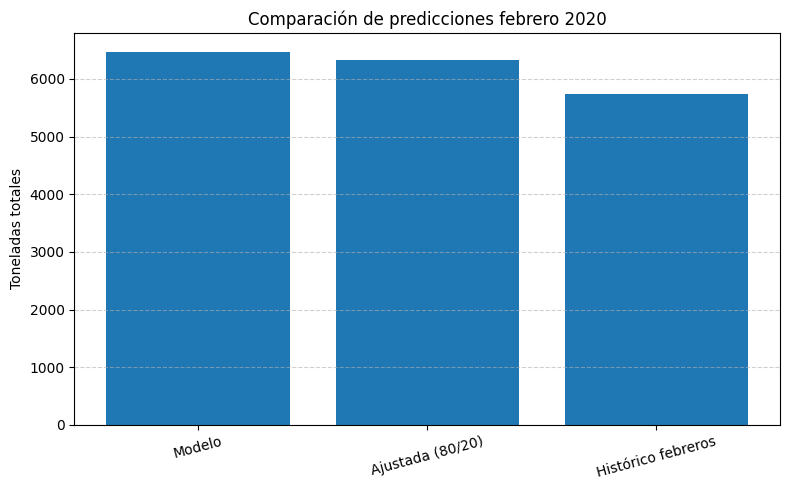

In [6]:
import pandas as pd
import matplotlib.pyplot as plt


total_modelo = 6475.05
total_ajustada = 6325.95
total_febrero_hist = 5729.57
# Crear DataFrame para graficar
data = {
    'Tipo de predicción': ['Modelo', 'Ajustada (80/20)', 'Histórico febreros'],
    'Toneladas': [total_modelo, total_ajustada, total_febrero_hist]
}
df_plot = pd.DataFrame(data)

# Graficar
plt.figure(figsize=(8, 5))
plt.bar(df_plot['Tipo de predicción'], df_plot['Toneladas'])
plt.ylabel('Toneladas totales')
plt.title('Comparación de predicciones febrero 2020')
plt.xticks(rotation=15)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


In [7]:
# Crear DataFrame con valores reales y predichos para diciembre 2019
val_resultado = val_data[['product_id', 'tn']].copy()
val_resultado.rename(columns={'tn': 'tn_real'}, inplace=True)
val_resultado['tn_predicho'] = y_pred_val

# Calcular MAE por producto
mae_por_producto = val_resultado.groupby('product_id').apply(
    lambda x: mean_absolute_error(x['tn_real'], x['tn_predicho'])
).reset_index(name='mae')

# Mostrar los productos con peor desempeño
print(mae_por_producto.sort_values('mae', ascending=False).head(10))


NameError: name 'val_data' is not defined

In [8]:
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

# 1. Cargar y preparar datos
df = pd.read_csv("top_20_corr.csv")
df['periodo'] = pd.to_datetime(df['periodo'])

# 2. Agrupar por producto y mes
df_prod = df.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()

# 3. Promedio histórico de febreros (2017–2019)
feb_hist = df_prod[
    (df_prod['periodo'].dt.month == 2) & (df_prod['periodo'].dt.year < 2020)
].groupby('product_id')['tn'].mean().reset_index()
feb_hist.rename(columns={'tn': 'febrero_hist'}, inplace=True)

# 4. Media móvil 12 meses
df_prod = df_prod.sort_values(['product_id', 'periodo'])
df_prod['media_movil_12m'] = (
    df_prod.groupby('product_id')['tn']
    .transform(lambda x: x.rolling(window=12, min_periods=1).mean())
)

# 5. Crear lags
def crear_lags(df, lags=[1, 2, 3]):
    df_lags = df.copy()
    for lag in lags:
        df_lags[f'lag_{lag}'] = df_lags.groupby('product_id')['tn'].shift(lag)
    return df_lags

df_lags = crear_lags(df_prod)
df_lags['mes'] = df_lags['periodo'].dt.month

# 6. Features derivados
df_lags['var_lag1_lag2'] = df_lags['lag_1'] / df_lags['lag_2']
df_lags['delta_lag1_lag2'] = df_lags['lag_1'] - df_lags['lag_2']
df_lags['delta_rel_lag1_lag2'] = df_lags['delta_lag1_lag2'] / df_lags['lag_2']
df_lags['delta_ma12_lag1'] = df_lags['lag_1'] - df_lags['media_movil_12m']
df_lags.replace([float('inf'), -float('inf')], pd.NA, inplace=True)

# 7. Preparar entrenamiento
df_train = df_lags.dropna()
features = [
    'lag_1', 'lag_2', 'lag_3', 'mes',
    'media_movil_12m', 'var_lag1_lag2',
    'delta_lag1_lag2', 'delta_rel_lag1_lag2', 'delta_ma12_lag1'
]
target = 'tn'

train_data = df_train[df_train['periodo'] < '2019-12-01']
val_data = df_train[df_train['periodo'] == '2019-12-01']

X_train = train_data[features].astype('float32')
y_train = train_data[target]
X_val = val_data[features].astype('float32')
y_val = val_data[target]

# 8. Entrenar modelo
mejores_params = {
    'n_estimators': 200,
    'learning_rate': 0.03244248607245155,
    'max_depth': 7,
    'num_leaves': 214,
    'subsample': 0.5578159124217413,
    'colsample_bytree': 0.8356752549785926,
    'random_state': 42,
    'min_data_in_leaf': 28,
    'reg_alpha': 0.2821665266006608,
    'reg_lambda': 2.364955845083401,
    'linear_tree': True
}
modelo = lgb.LGBMRegressor(**mejores_params)
modelo.fit(X_train, y_train)

# 9. Validación
y_pred_val = modelo.predict(X_val)
print("📊 MAE en diciembre 2019:", mean_absolute_error(y_val, y_pred_val))

# 10. Preparar df para febrero 2020
feb_df = pd.DataFrame()
feb_df['product_id'] = df_prod['product_id'].unique()
feb_df['periodo'] = pd.to_datetime('2020-02-01')
feb_df['mes'] = 2

# Usar media móvil de diciembre 2019 como proxy de lag_1
lag1_df = df_prod[df_prod['periodo'] == '2019-12-01'][['product_id', 'media_movil_12m']]
lag1_df = lag1_df.rename(columns={'media_movil_12m': 'lag_1'})
feb_df = feb_df.merge(lag1_df, on='product_id', how='left')

# Agregar lag_2 y lag_3 reales
lag2 = df_prod[df_prod['periodo'] == '2019-12-01'][['product_id', 'tn']].rename(columns={'tn': 'lag_2'})
lag3 = df_prod[df_prod['periodo'] == '2019-11-01'][['product_id', 'tn']].rename(columns={'tn': 'lag_3'})
feb_df = feb_df.merge(lag2, on='product_id', how='left')
feb_df = feb_df.merge(lag3, on='product_id', how='left')

# Media móvil
media_mov = df_prod[df_prod['periodo'] == '2019-12-01'][['product_id', 'media_movil_12m']]
feb_df = feb_df.merge(media_mov, on='product_id', how='left')

# Calcular deltas
feb_df['var_lag1_lag2'] = feb_df['lag_1'] / feb_df['lag_2']
feb_df['delta_lag1_lag2'] = feb_df['lag_1'] - feb_df['lag_2']
feb_df['delta_rel_lag1_lag2'] = feb_df['delta_lag1_lag2'] / feb_df['lag_2']
feb_df['delta_ma12_lag1'] = feb_df['lag_1'] - feb_df['media_movil_12m']
feb_df.replace([float('inf'), -float('inf')], pd.NA, inplace=True)

# Merge con histórico de febreros
feb_df = feb_df.merge(feb_hist, on='product_id', how='left')

# 11. Predicción
feb_df['tn_predicho'] = modelo.predict(feb_df[features].astype('float32'))
feb_df['tn_predicho_ajustada'] = 0.8 * feb_df['tn_predicho'] + 0.2 * feb_df['febrero_hist']

# 12. Exportar
resultado = feb_df[['product_id', 'tn_predicho_ajustada']].rename(columns={'tn_predicho_ajustada': 'tn_predicho'})
resultado.to_csv("prediccion_feb2020_top20_2.csv", index=False)
print("✅ Predicción febrero 2020 guardada con lag_1 basado en media móvil en prediccion_feb2020_top20_2.csv")


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2053
[LightGBM] [Info] Number of data points in the train set: 4260, number of used features: 9
[LightGBM] [Info] Start training from score 46.448501
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

In [9]:
import pandas as pd

# 1. Cargar predicción de febrero 2020
df_pred = pd.read_csv("prediccion_feb2020_top20_2.csv")  # archivo generado por el modelo
df_pred['periodo'] = pd.to_datetime("2020-02-01")
df_pred.rename(columns={'tn_predicho': 'tn'}, inplace=True)

# 2. Cargar dataset original
df_real = pd.read_csv("top_20_corr.csv")
df_real["periodo"] = pd.to_datetime(df_real["periodo"])

# 3. Agrupar por período y sumar toneladas reales
tn_reales = df_real.groupby(["periodo"])["tn"].sum().reset_index()

# 4. Sumar toneladas predichas para febrero 2020
tn_feb2020 = df_pred.groupby("periodo")["tn"].sum().reset_index()

# 5. Unir y ordenar
comparacion = pd.concat([tn_reales, tn_feb2020], ignore_index=True)
comparacion = comparacion.sort_values("periodo").reset_index(drop=True)

# 6. Mostrar resultado
print("📊 Total de toneladas por período (incluye predicción febrero 2020):")
print(comparacion.tail(36))  # los últimos 12 períodos


📊 Total de toneladas por período (incluye predicción febrero 2020):
      periodo           tn
1  2017-02-01  5702.329240
2  2017-03-01  6990.975080
3  2017-04-01  5915.823280
4  2017-05-01  6350.693500
5  2017-06-01  6246.929910
6  2017-07-01  4963.102670
7  2017-08-01  5394.165890
8  2017-09-01  6456.906460
9  2017-10-01  7469.616590
10 2017-11-01  6673.993390
11 2017-12-01  5439.856720
12 2018-01-01  5008.784730
13 2018-02-01  5276.024020
14 2018-03-01  8091.698880
15 2018-04-01  5935.535300
16 2018-05-01  6872.360550
17 2018-06-01  6240.219870
18 2018-07-01  5481.642500
19 2018-08-01  6211.813170
20 2018-09-01  5654.181890
21 2018-10-01  6470.025550
22 2018-11-01  6228.277660
23 2018-12-01  4976.507710
24 2019-01-01  5998.069700
25 2019-02-01  6210.342500
26 2019-03-01  6873.226760
27 2019-04-01  6573.771380
28 2019-05-01  6877.301310
29 2019-06-01  6301.710090
30 2019-07-01  6554.508120
31 2019-08-01  5666.678680
32 2019-09-01  7172.001220
33 2019-10-01  7370.981940
34 2019-11-01 


📌 Importancia de variables:
               feature  importancia
3                  mes         1027
4      media_movil_12m          949
0                lag_1          803
8      delta_ma12_lag1          769
1                lag_2          743
2                lag_3          737
6      delta_lag1_lag2          485
5        var_lag1_lag2          457
7  delta_rel_lag1_lag2           92


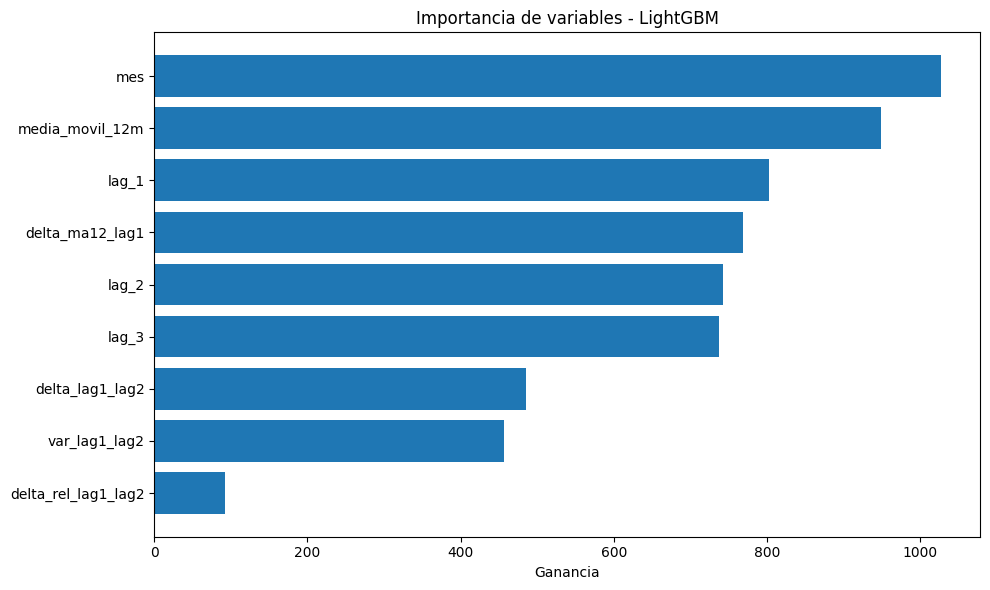

In [10]:
# 🔍 Importancia de variables
import matplotlib.pyplot as plt

# Crear DataFrame con la importancia
importancias = pd.DataFrame({
    'feature': modelo.feature_name_,
    'importancia': modelo.feature_importances_
}).sort_values(by='importancia', ascending=False).head(10)

# Mostrar en consola
print("\n📌 Importancia de variables:")
print(importancias)

# Graficar
plt.figure(figsize=(10, 6))
plt.barh(importancias['feature'], importancias['importancia'])
plt.gca().invert_yaxis()
plt.title("Importancia de variables - LightGBM")
plt.xlabel("Ganancia")
plt.tight_layout()
plt.show()
